In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
# !pip3 install geompreds
from geompreds import orient2d, incircle
from sklearn.cluster import KMeans
from scipy.stats import entropy

In [2]:
# utils 
def find_matches(descr1, descr2, pct):
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    flann = cv.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(descr1, descr2, k=2)
    #print(len(matches))
    # store all the good matches as per Lowe's ratio test.
    good = []
    for m, n in matches:
        if m.distance < pct*n.distance:
            good.append(m)
    #print("matches {}".format(len(good)))
    return good

def find_homography_and_box(src_pts, dst_pts, template, target):
    H, mask = cv.findHomography(src_pts, dst_pts,
                                cv.RANSAC, 5.0)
    matchesMask = mask.ravel().tolist()
    h,w,d = template.shape
    pts = np.float32([[0, 0], [0, h - 1], 
                  [w - 1, h - 1], [w - 1, 0] ]).reshape(-1,1,2)
    box = cv.perspectiveTransform(pts, H)
    img2 = cv.polylines(target, [np.int32(box)],
                        True, (0, 0,255),
                        3, cv.LINE_AA)
    return H, box, matchesMask

def remove_matched_points(kpts2, descr2, box):
    for idx in reversed(range(len(kpts2) - 1)):
        kp_2 = kpts2[idx]

        if inside_box(box, kp_2):
            descr2 = np.delete(descr2, idx, 0)
            del kpts2[idx]

    return kpts2, descr2

def inside_box(box, kpt):
    x_low = box.reshape((4, 2)).min(axis=0)[1]
    x_high = box.reshape((4, 2)).max(axis=0)[1]
    y_low = box.reshape((4, 2)).min(axis=0)[0]
    y_high = box.reshape((4, 2)).max(axis=0)[0]
    
    x = kpt.pt[1]
    y = kpt.pt[0]
    
    x_cond = x_low <= x <= x_high
    y_cond = y_low <= y <= y_high
    return x_cond and y_cond
    

In [3]:
def share_points(good_matches_one, good_matches_two):
    ids_one = [m.trainIdx for m in good_matches_one]
    ids_two = [m.trainIdx for m in good_matches_two]
    shared_matches = [m for m in good_matches_one if m.trainIdx in ids_two]
    return shared_matches

def is_convex(box, template, H):
    transformed_template = []
    template_shape = np.array([[0,0,1],[template.shape[1],0,1],[template.shape[1],template.shape[0],1],[0,template.shape[0],1]])    
    for p in template_shape:
        trasformated = H @ p#np.concatenate((p[0],np.array([1])))
        transformed_template.append(trasformated/trasformated[2])
    transformed_template = np.array(transformed_template)[:,[0,1]]
    
    for i in range(4):
        orientation = orient2d(transformed_template[i],transformed_template[(i+1)%4],transformed_template[(i+2)%4])
        if(orientation<=0):
            return False
    return True

def check_quality_diego(box, template, H):
    template_area = template.shape[0] * template.shape[1]
    
    x_low = box.reshape((4, 2)).min(axis=0)[1]
    x_high = box.reshape((4, 2)).max(axis=0)[1]
    x_diff = x_high - x_low
    
    y_low = box.reshape((4, 2)).min(axis=0)[0]
    y_high = box.reshape((4, 2)).max(axis=0)[0]
    y_diff = y_high - y_low
    
    match_area = x_diff * y_diff
    
    ratio = template_area/match_area
    
    if 1< ratio < 3:
        return ratio, True
    else:
        return ratio, False

In [4]:
MIN_NUM_MATCHES_ONE = 8
MIN_NUM_MATCHES_TWO = 8
template = cv.imread('cropped_template.jpeg')
template = cv.cvtColor(template, cv.COLOR_BGR2RGB)

template2 = cv.imread('template1.png')
template2 = cv.cvtColor(template2, cv.COLOR_BGR2RGB)

target = cv.imread('target1.png')
target = cv.cvtColor(target, cv.COLOR_BGR2RGB)

sift = cv.xfeatures2d.SIFT_create()
kp1, descr1 = sift.detectAndCompute(template, None)
kp2, descr2 = sift.detectAndCompute(template2, None)

kpzero, descrzero = sift.detectAndCompute(target, None)

# Multiple template with image segmentation.

# Using CNN

## CNN results
See ```https://colab.research.google.com/drive/17I5Gikwe4v7sg-bEGGYQ9vwIFCt65ofT?usp=sharing```
for cnn training/predicition

In [5]:
# We load cnn segmentation from saved results (segmention process was ran outside)
alt_clusts = np.load('res_2.np', allow_pickle=True) # segmention of two clusters
np.unique(alt_clusts)

array([84, 87])

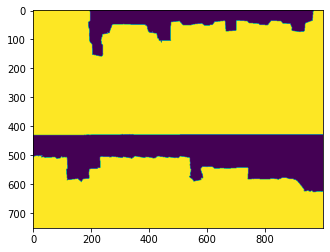

In [6]:
plt.figure(figsize=(10, 4))
plt.imshow(alt_clusts.reshape((target.shape[0], target.shape[1])))

In [7]:
# Different mappings for clusters/segments through CNN
map_10 = {14:0, 17:1, 21:2, 29:3, 33:4, 63:5, 69:6, 78:7, 79:8, 91:9}
map_4 = {14:0, 20:1, 66:2, 97:3}
map_3 = {7:0, 54:1, 81:2}
map_2 = {84:0, 87:1}

In [8]:
MIN_NUM_MATCHES_ONE = 8
MIN_NUM_MATCHES_TWO = 10
template = cv.imread('cropped_template.jpeg')
template = cv.cvtColor(template, cv.COLOR_BGR2RGB)

template2 = cv.imread('template1.png')
template2 = cv.cvtColor(template2, cv.COLOR_BGR2RGB)

target = cv.imread('target1.png')
target = cv.cvtColor(target, cv.COLOR_BGR2RGB)

sift = cv.xfeatures2d.SIFT_create()
kp1, descr1 = sift.detectAndCompute(template, None)
kp2, descr2 = sift.detectAndCompute(template2, None)

kpzero, descrzero = sift.detectAndCompute(target, None)


flat_img = target.reshape(-1, 1)
print(flat_img.shape)
n_clusters = 2

use_KMeans = False


if use_KMeans:
    KM = KMeans(n_clusters=n_clusters)
    result_KM = KM.fit(flat_img)

kp_cluster = []
x_max, y_max, _ = target.shape

# Iterate over the keypoints
# and assign a cluster
# c1: kp1, kp2, kp4...
# c2: kp5, kp3, kp8

for idx, kpt in enumerate(kpzero):
    pt = kpt.pt
    rounded_pt = np.round(pt).astype(np.int32)
    rd_x = rounded_pt[1] if rounded_pt[1] <= x_max - 1 else x_max - 1
    rd_y = rounded_pt[0] if rounded_pt[0] <= y_max - 1 else y_max - 1
    if use_KMeans:
        cluster_votes = result_KM.labels_.reshape(target.shape)[rd_x, rd_y, :]
        vals, counts = np.unique(cluster_votes, return_counts=True)
        assigned_cluster = vals[np.argmax(counts)]
    else:
        cluster_votes = alt_clusts.reshape((target.shape[0], target.shape[1]))[rd_x, rd_y]
        vals, counts = np.unique(cluster_votes, return_counts=True)
        assigned_cluster = map_2[vals[np.argmax(counts)]]

    kp_cluster.append((kpt, assigned_cluster, descrzero[idx]))

cluster_lists = {}
for clust_num in range(n_clusters):
    cluster_lists[clust_num] = {}
    clust_data = cluster_lists[clust_num]
    clust_data['keypoints'] = [kpt for kpt, c, _ in kp_cluster if c == clust_num]
    clust_data['descriptors'] = [sift for kpt, c, sift in kp_cluster if c == clust_num]

clust_matches = {}
clust_matches2 = {}
for clust_num in range(n_clusters):
    print("cluster {}".format(clust_num))
    clust_descriptors = np.array(cluster_lists[clust_num]['descriptors'])
    clust_matches[clust_num] = find_matches(descr1, clust_descriptors, 0.8)
    clust_matches2[clust_num] = find_matches(descr2, clust_descriptors, 0.8)

biggest_cluster = 0
match_size = -1 
best_metric = -1
for clust_num, matches in clust_matches.items():
    clust_cnn = 87 if clust_num == 1 else 84
    if use_KMeans:
        mask = 1*(result_KM.labels_.reshape(target.shape)[:,:, 2] == biggest_cluster)
    else:
        mask = 1*(alt_clusts.reshape((target.shape[0], target.shape[1])) == clust_cnn)
    
    masked_img = cv.bitwise_and(target, target, mask = mask.astype(np.uint8))
    msk_image8bit = cv.normalize(masked_img, None, 0, 255, cv.NORM_MINMAX).astype('uint8')
    clust_entropy = entropy(msk_image8bit.reshape(-1,1))
    
    metric = len(matches) / clust_entropy 

    if metric > best_metric:
        biggest_cluster = clust_num
        match_size = len(matches)
        best_metric = metric

biggest_cluster2 = 0
match_size2 = -1 
best_metric2 = -1
for clust_num, matches in clust_matches2.items():
    
    clust_cnn = 87 if clust_num == 1 else 84
    if use_KMeans:
        mask = 1*(result_KM.labels_.reshape(target.shape)[:,:, 2] == biggest_cluster)
    else:
        mask = 1*(alt_clusts.reshape((target.shape[0], target.shape[1])) == clust_cnn)
    
    masked_img = cv.bitwise_and(target, target, mask = mask.astype(np.uint8))
    msk_image8bit = cv.normalize(masked_img, None, 0, 255, cv.NORM_MINMAX).astype('uint8')
    clust_entropy = entropy(msk_image8bit.reshape(-1,1))
    
    metric = len(matches) / clust_entropy 
    
    if metric > best_metric2:
        biggest_cluster2 = clust_num
        match_size2 = len(matches)
        best_entropy2 = clust_entropy


biggest_cluster, biggest_cluster2

(2250000, 1)
cluster 0
cluster 1


(1, 1)

In [9]:
#biggest_cluster, biggest_cluster2 = 4, 4
map_2

{84: 0, 87: 1}

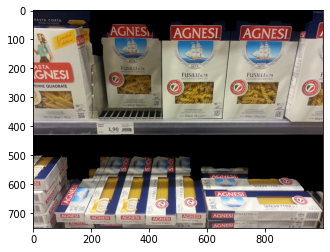

In [10]:
image = cv.imread('target1.png')
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
if use_KMeans:
    mask = 1*(result_KM.labels_.reshape(target.shape)[:,:, 2] == biggest_cluster)
else:
    clust_cnn = 87 if biggest_cluster == 1 else 84
    mask = 1*(alt_clusts.reshape((target.shape[0], target.shape[1])) == clust_cnn)

masked_img = cv.bitwise_and(image, image, mask = mask.astype(np.uint8))
msk_image8bit = cv.normalize(masked_img, None, 0, 255, cv.NORM_MINMAX).astype('uint8')
plt.imshow(msk_image8bit)
# Masked image through segmentation

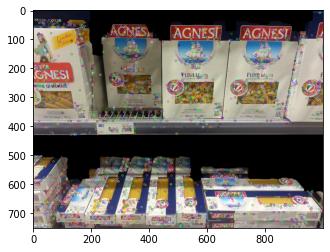

In [11]:
biggest_kp = cluster_lists[biggest_cluster]['keypoints']
biggest_descr = np.array(cluster_lists[biggest_cluster]['descriptors'])

img = cv.drawKeypoints(msk_image8bit, biggest_kp, None)
plt.imshow(img)

In [12]:
image = cv.imread('target1.png')
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

(3427, 128)


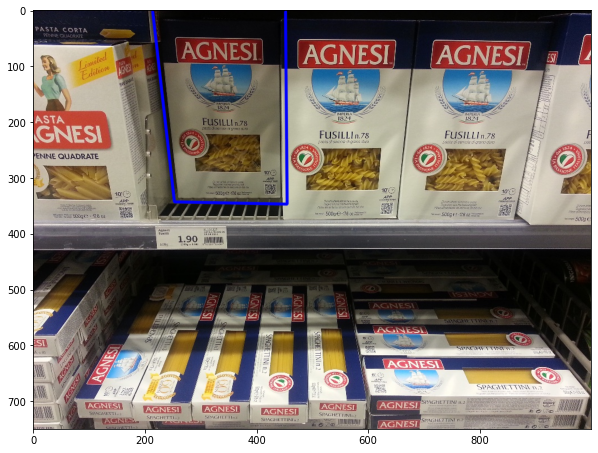

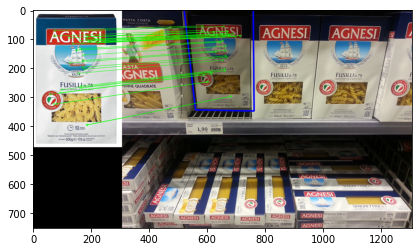

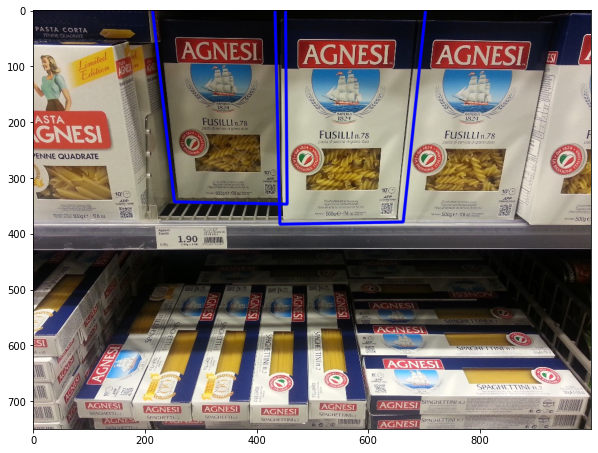

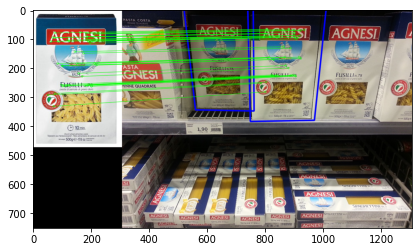

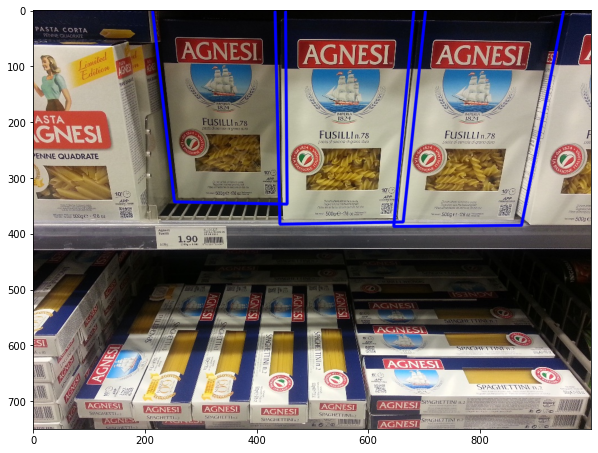

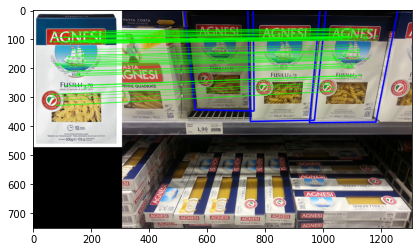

neither are valid homographies
neither are valid homographies


In [13]:
match_template_1 = True
match_template_2 = True
look_for_both = False
print(descrzero.shape)

for iter_ in range(100):

    if match_template_1:
        good_matches_one = find_matches(descr1, biggest_descr, 0.85)
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good_matches_one ]).reshape(-1,1,2) 
        dst_pts = np.float32([ biggest_kp[m.trainIdx].pt for m in good_matches_one ]).reshape(-1,1,2)

    if match_template_2:
        good_matches_two = find_matches(descr2, biggest_descr, 0.75)
        src_pts2 = np.float32([ kp2[m.queryIdx].pt for m in good_matches_two]).reshape(-1,1,2) 
        dst_pts2 = np.float32([ biggest_kp[m.trainIdx].pt for m in good_matches_two]).reshape(-1,1,2)


    if len(good_matches_one) < MIN_NUM_MATCHES_ONE:
        match_template_1 = False
    
    if len(good_matches_two) < MIN_NUM_MATCHES_TWO:
        match_template_2 = False

    if match_template_1:
        M, box, matchesMask = find_homography_and_box(src_pts, dst_pts,
                                                      template, target)
        check = is_convex(box, template, M)
        ratio, area_check = check_quality_diego(box, template, M)

    if match_template_2:
        M2, box2, matchesMask2 = find_homography_and_box(src_pts2, dst_pts2,
                                                         template2, target)
        ratio, area_check = check_quality_diego(box, template, M)
        check2 = is_convex(box2, template2, M2)
    
    if (not match_template_1) and (not match_template_2):
        print("done looking for both templates!!!!")
        break
    else:
        look_for_both = True

    if len(good_matches_two) > len(good_matches_one):
        best_match = good_matches_two
        best_src = src_pts2
        best_dst = dst_pts2
        best_M = M2
        best_box = box2
        best_Mask = matchesMask2
        best_temp = template2
        best_kp = kp2

    else:
        best_match = good_matches_one
        best_src = src_pts
        best_dst = dst_pts
        best_M = M
        best_box = box
        best_Mask = matchesMask
        best_temp = template
        best_kp = kp1

    check = is_convex(best_box, best_temp, best_M)
    ratio, area_check = check_quality_diego(best_box, best_temp, best_M)

    if (not check) and (not check2):
        print("neither are valid homographies")
        continue
    
    if look_for_both:
        shared_matches = share_points(good_matches_one, good_matches_two)

    if check and area_check:
        img2 = cv.polylines(image,[np.int32(best_box)],True,(0, 0,255),3, cv.LINE_AA)
        plt.figure(figsize=(10, 8))
        plt.imshow(img2)
        plt.show()

        draw_params = dict(matchColor = (0,255,0), # draw matches in green color
               singlePointColor = None,
               matchesMask = best_Mask, # draw only inliers
               flags = 2)
        img3 = cv.drawMatches(best_temp, best_kp,
                              img2, biggest_kp, 
                              best_match, None,**draw_params)

        plt.figure(figsize=(10, 4))
        plt.imshow(img3)
        plt.show()
        biggest_kp, biggest_descr = remove_matched_points(biggest_kp, biggest_descr, best_box)
        

# Keep looking for other templates closer on match terms 

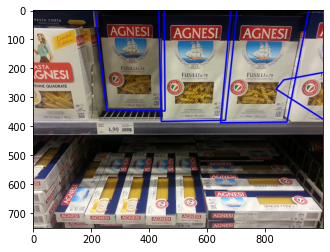

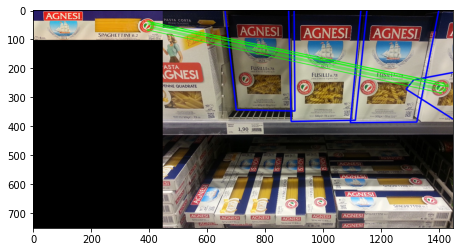

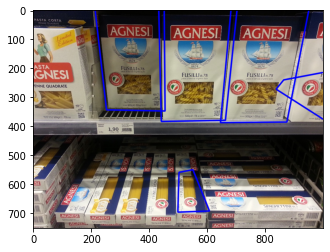

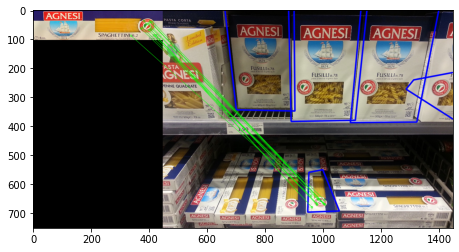

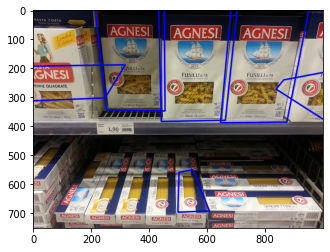

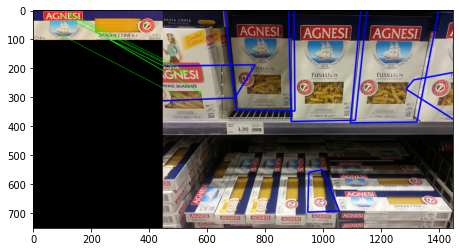

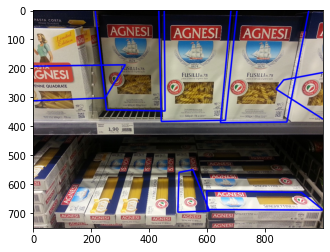

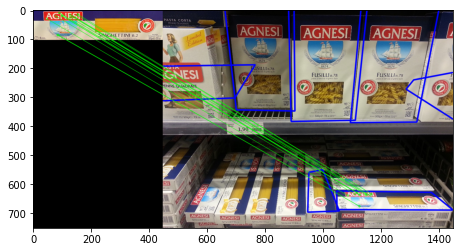

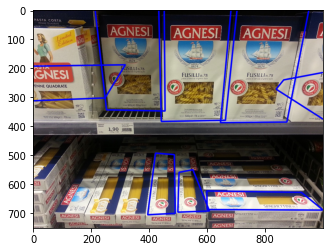

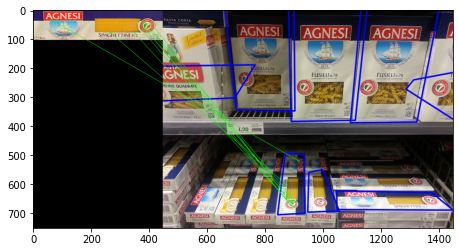

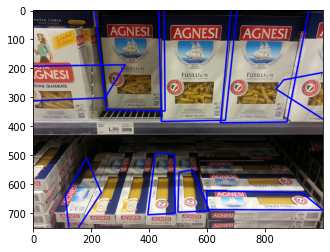

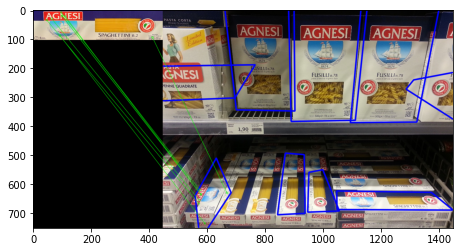

In [14]:
for iter_ in range(700): # we need a lot of iters to discover matches
    good_matches = find_matches(descr1, biggest_descr, 0.92)
    if len(good_matches) < MIN_NUM_MATCHES_ONE:
        print("not enough matches")
        break
    
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good_matches ]).reshape(-1,1,2) 
    dst_pts = np.float32([ biggest_kp[m.trainIdx].pt for m in good_matches ]).reshape(-1,1,2)

    M, box, matchesMask = find_homography_and_box(src_pts, dst_pts, template, target)
    
    #to apply the transformation of the first match to the target later.     
    
    #Check if the match is good enough     
    convex_check = is_convex(box, template, M)
    ratio, area_check = check_quality_diego(box, template, M)
    
    if convex_check and area_check:
        img2 = cv.polylines(image,[np.int32(box)],True,(0, 0,255),3, cv.LINE_AA)
        plt.figure(figsize=(10, 4))
        plt.imshow(img2)
        plt.show()

        draw_params = dict(matchColor = (0,255,0), # draw matches in green color
               singlePointColor = None,
               matchesMask = matchesMask, # draw only inliers
               flags = 2)
        img3 = cv.drawMatches(template, kp1,
                              img2, biggest_kp, 
                              good_matches, None,**draw_params)
        plt.figure(figsize=(10, 4))
        plt.imshow(img3)
        plt.show()
        biggest_kp, biggest_descr = remove_matched_points(biggest_kp, biggest_descr, box)